@author: James V. Talwar 

# Discovery Set Analysis: Autoimmune Alleles and Age of Diagnosis

**About:** This notebook provides the code needed to generate Figure 1 panels A,C,D,E and Supplementary Figure 8 from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses evaluated MHC-I autoimmune allele status in skin cutaneous melanoma (SKCM) cases in the TCGA.

## 1. Import Packages; Load and Format Data

In [1]:
import pandas as pd
from pathlib import Path
import os
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist()) #{'HLA-B13:02','HLA-B27:05','HLA-B51:01','HLA-B57:01','HLA-C06:02','HLA-C12:03', "HLA-B39:06"} 
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Get the total number of class-I AI alleles per individual
numTotalAIAlleles = []
for i,row in tcgaSummary.iterrows():
    howManyTotal = 0
    for allele in row["A1":"C2"]:
        if allele in autoimmuneAlleles:
            howManyTotal += 1
    numTotalAIAlleles.append(howManyTotal)
    
tcgaSummary["NumTotalAIAlleles"] = numTotalAIAlleles

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

In [3]:
tcgaClinical = pd.read_csv("../GenotypeData/TCGA_SKCM_Clinical.txt", sep = "\t", index_col = 1)
tcgaClinical = tcgaClinical[tcgaClinical.index.isin(tcgaSummary.index)]

## 2. Run Analyses and  Generate Figures 

### 2a. Figure 1A

Statistical Test: MWU test by age of diagnosis between AI allele carriers and non-carriers 

In [4]:
stat, pProtection = mannwhitneyu(tcgaSummary[(tcgaSummary.HasProtection)&(tcgaSummary.Age >= 20)].Age, tcgaSummary[(tcgaSummary["HasProtection"] == False)&(tcgaSummary.Age >= 20)].Age)
print('MWU: Statistic = %.3f, p= %.5f' % (stat, pProtection))

MWU: Statistic = 20774.500, p= 0.00163


Generate figure:

Text(0.43, 95, '**')

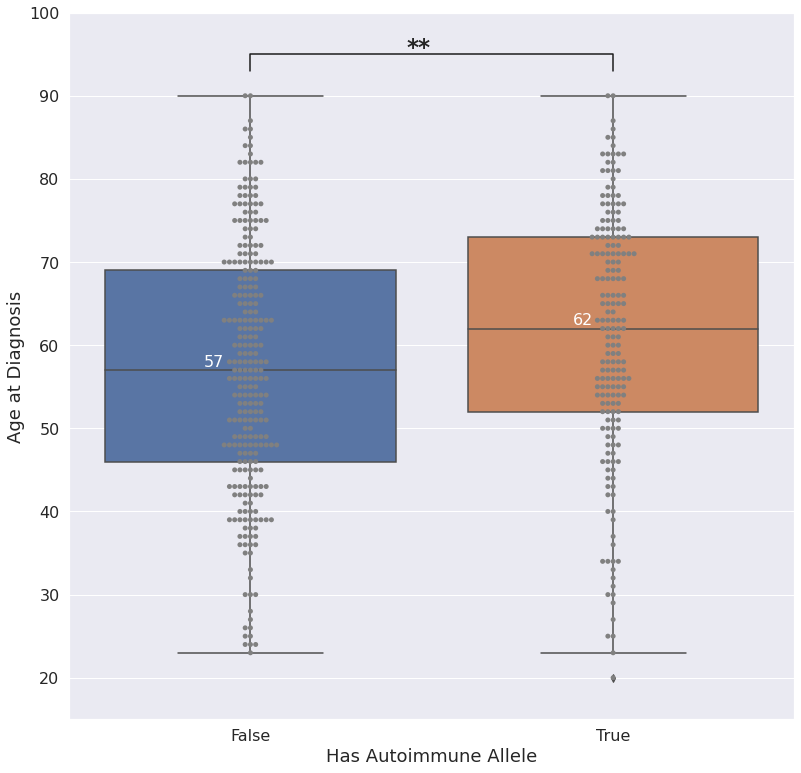

In [5]:
sns.set(font_scale = 1.1)
plt.figure(figsize=(13,13))

sns.boxplot(data = tcgaSummary, x = "HasProtection", y = "Age") #.set(xlabel='Has Autoimmune Allele',   ylabel='Age')
plt.ylim(15,100)
sns.swarmplot(data = tcgaSummary, x = "HasProtection", y = "Age", color ='grey')
plt.xlabel('Has Autoimmune Allele', fontsize= 18)
plt.ylabel("Age at Diagnosis", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.text(-.13, 57.5, str(int(np.median(tcgaSummary[(tcgaSummary["HasProtection"] == False)]["Age"]))), color = "white", fontsize = 16)
plt.text(0.89, 62.5, str(int(np.median(tcgaSummary[tcgaSummary["HasProtection"]]["Age"]))), color = "white", fontsize = 16)

plt.plot([0,0,1,1], [93, 95, 95, 93], lw = 1.5, c = 'k')
plt.text(0.43, 95, "**", fontsize = 23, fontweight = "bold")

In [6]:
tcgaSummary.HasProtection.value_counts()

False    261
True     190
Name: HasProtection, dtype: int64

### 2b. Figure 1C

Statistical Test: MWU test by age of diagnosis between AI allele carriers and non-carriers in both males and females

In [7]:
print("Running mann-whitney for AI alleles in FEMALES...: ")
stat,pFemale = mannwhitneyu(tcgaSummary[(tcgaSummary["Sex"] == "female")&(tcgaSummary["HasProtection"])].Age, tcgaSummary[(tcgaSummary["Sex"] == "female")&(tcgaSummary["HasProtection"]==False)].Age)
print('MWU: Statistic = %.3f, p= %.3f\n' % (stat, pFemale))

print("Running mann-whitney for AI alleles in MALES...: ")
stat,pMale = mannwhitneyu(tcgaSummary[(tcgaSummary["Sex"] == "male")&(tcgaSummary["HasProtection"])].Age, tcgaSummary[(tcgaSummary["Sex"] == "male")&(tcgaSummary["HasProtection"]==False)].Age)
print('Statistic = %.3f, p= %.3f' % (stat, pMale))

Running mann-whitney for AI alleles in FEMALES...: 
MWU: Statistic = 2997.000, p= 0.033

Running mann-whitney for AI alleles in MALES...: 
Statistic = 7978.000, p= 0.011


Generate figure:

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

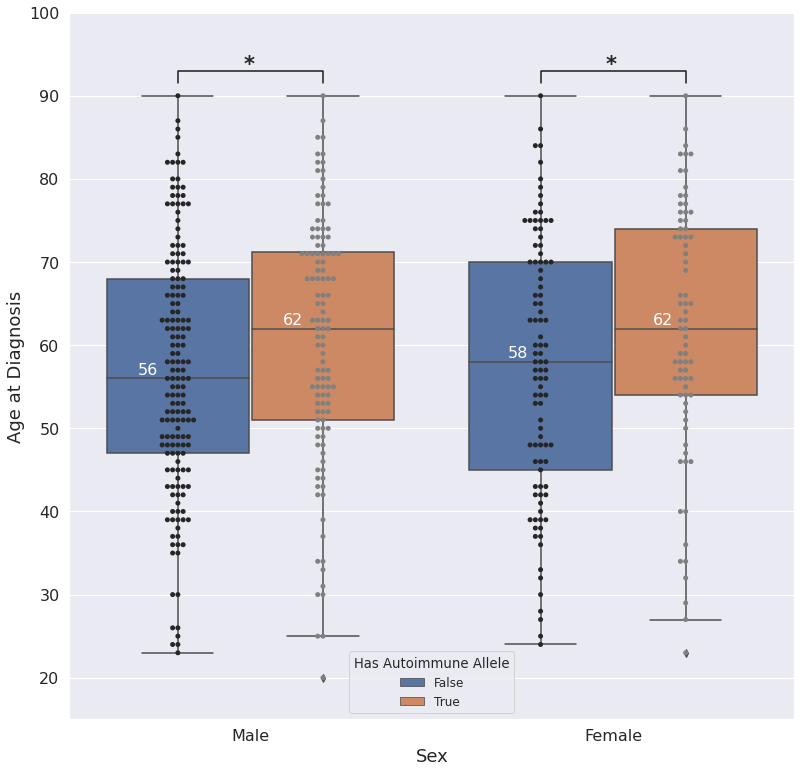

In [8]:
plt.figure(figsize=(13,13)), 
ax = sns.boxplot(data = tcgaSummary, x = "Sex", y = "Age", hue = "HasProtection")
sns.swarmplot(data = tcgaSummary, x = "Sex", y = "Age", hue = "HasProtection", color="gray", dodge=True)

plt.plot([-0.2,-0.2,0.2,0.2], [91.5, 93, 93, 91.5], lw = 1.5, c = 'k')
plt.text(-0.02, 93, "*", fontsize = 21, fontweight = "bold") 
plt.plot([0.8,0.8,1.2,1.2], [91.5, 93, 93, 91.5], lw = 1.5, c = 'k')
plt.text(0.98, 93, "*", fontsize = 21, fontweight = "bold") 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title = "Has Autoimmune Allele", loc = 8)

plt.ylabel("Age At Diagnosis")

plt.text(-0.31, 56.5, int(np.median(tcgaSummary[(tcgaSummary["HasProtection"] == False)&(tcgaSummary["Sex"] == "male")]["Age"])), color = "white", fontsize = 16)
plt.text(0.09, 62.5, int(np.median(tcgaSummary[(tcgaSummary["HasProtection"])&(tcgaSummary["Sex"] == "male")]["Age"])), color = "white", fontsize = 16)

plt.text(0.71, 58.5, int(np.median(tcgaSummary[(tcgaSummary["HasProtection"] == False)&(tcgaSummary["Sex"] == "female")]["Age"])), color = "white", fontsize = 16)
plt.text(1.11, 62.5, int(np.median(tcgaSummary[(tcgaSummary["HasProtection"])&(tcgaSummary["Sex"] == "female")]["Age"])), color = "white", fontsize = 16)
plt.ylim(15, 100)


plt.xticks([0,1], ["Male", "Female"], fontsize = 16)

plt.ylabel("Age at Diagnosis", fontsize = 18)
plt.xlabel("Sex", fontsize = 18)
plt.yticks(fontsize = 16)

## 2c. Figure 1D and Supplementary Figure 8

**Data Formatting:** Map clinical stage levels to numerical and local/diffuse classifications:

In [9]:
#local vs metastatic:
stageToPrimaryVsMetastatic = {'I/II NOS': "LOCAL", 'Stage 0': "LOCAL", 'Stage I': "LOCAL", 'Stage IA': "LOCAL", 'Stage IB': "LOCAL",'Stage II': "LOCAL", 'Stage IIA': "LOCAL", 'Stage IIB': "LOCAL", 'Stage IIC': "LOCAL",'Stage III': "METASTATIC",
 'Stage IIIA': "METASTATIC",
 'Stage IIIB': "METASTATIC",
 'Stage IIIC':  "METASTATIC",
 'Stage IV': "METASTATIC",
 '[Not Available]': None}

#clinical to numerical:
stageToNumber = {'I/II NOS': 1, 'Stage 0': 0, 'Stage I': 1, 'Stage IA': 1, 'Stage IB': 1,'Stage II': 2, 'Stage IIA': 2, 'Stage IIB': 2, 'Stage IIC': 2,'Stage III': 3,
 'Stage IIIA': 3,
 'Stage IIIB': 3,
 'Stage IIIC':  3,
 'Stage IV': 4,
 '[Not Available]': None}

In [10]:
#Add clinical labels to DF
tcgaSummary["Stage"] = [tcgaClinical.loc[i, "ajcc_pathologic_tumor_stage"] for i in tcgaSummary.index]
tcgaSummary["Thickness"] = [tcgaClinical.loc[i, "breslow_thickness_at_diagnosis"] for i in tcgaSummary.index]

In [11]:
#Add Mapped local vs. diffuse and numerical stage to DF as well
tcgaSummary["PrimaryVsMetastatic"] = tcgaSummary["Stage"].map(stageToPrimaryVsMetastatic)
tcgaSummary["StageNumericEncoding"] = tcgaSummary["Stage"].map(stageToNumber)

#Encode Female status to be True (rather than letting smf randomly picking one and flipping the coefficient - done for consistency of results)
tcgaSummary["C_Sex"] = [el == "female" for el in tcgaSummary.Sex] 

**2c.1 Figure 1C and relevant statistical analyses**

Linear model: $$Age Of Diagnosis \sim AI status + Sex + Mutation Burden + Breslow Thickness $$

In [12]:
thoseWithThickness = tcgaSummary[tcgaSummary.Thickness != "[Not Available]"]
thoseWithThickness["Thickness"] = thoseWithThickness["Thickness"].astype(float)
print("There are {} individuals in discovery with tumor thickness available".format(thoseWithThickness.shape[0]))

discoveryWithThickness = smf.ols(formula= 'Age ~ HasProtection+C_Sex+NumberMutations+Thickness', data=thoseWithThickness).fit()
thickSummary = discoveryWithThickness.summary()
thickSummary.tables[1]

/cellar/users/jtalwar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


There are 347 individuals in discovery with tumor thickness available


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,53.9070,1.498,35.993,0.000,50.961,56.853
HasProtection[T.True],4.7619,1.617,2.945,0.003,1.581,7.943
C_Sex[T.True],0.6864,1.647,0.417,0.677,-2.553,3.926
NumberMutations,0.0061,0.002,3.544,0.000,0.003,0.009
Thickness,0.2508,0.093,2.704,0.007,0.068,0.433


In [13]:
#List all p-values from linear model
discoveryWithThickness.pvalues

Intercept                2.386993e-118
HasProtection[T.True]     3.454111e-03
C_Sex[T.True]             6.770714e-01
NumberMutations           4.482002e-04
Thickness                 7.185056e-03
dtype: float64

Generate figure:

In [14]:
#Format results in convenient manner for plotting:
resultsHTML = thickSummary.tables[1].as_html()
summaryDF = pd.read_html(resultsHTML, header =0, index_col = 0)[0]
summaryDF["Labels"] = summaryDF.index
summaryDF["DoubleTrouble"] = 2*summaryDF["std err"]
summaryDF = summaryDF.drop(["Intercept"], axis = 0)
summaryDF.Labels = ["Has Autoimmune Allele", "Sex", "Mutation Burden", "Breslow Thickness"]
summaryDF

,coef,std err,t,P>|t|,[0.025,0.975],Labels,DoubleTrouble
HasProtection[T.True],4.7619,1.617,2.945,0.003,1.581,7.943,Has Autoimmune Allele,3.234
C_Sex[T.True],0.6864,1.647,0.417,0.677,-2.553,3.926,Sex,3.294
NumberMutations,0.0061,0.002,3.544,0.000,0.003,0.009,Mutation Burden,0.004
Thickness,0.2508,0.093,2.704,0.007,0.068,0.433,Breslow Thickness,0.186


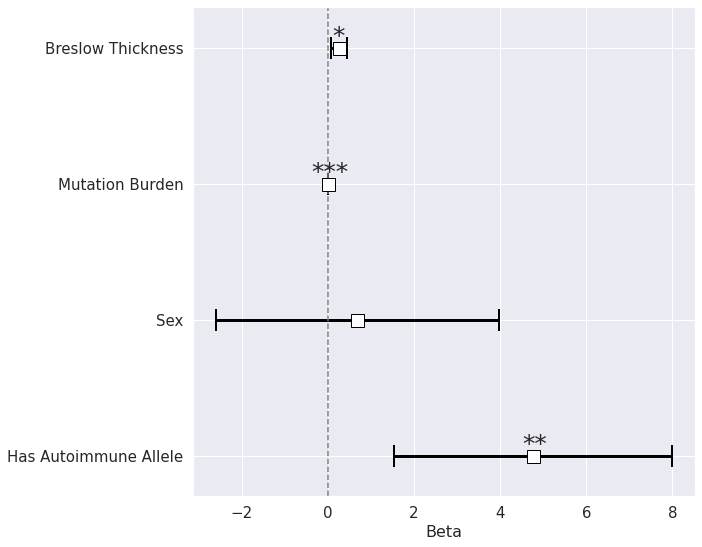

In [15]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.set(font_scale=1.1)
plt.errorbar(summaryDF.coef, summaryDF.Labels, xerr=summaryDF.DoubleTrouble, fmt='s', mfc = "white",color='black',
             ecolor='black', elinewidth=3, capsize = 11, markersize = 13, capthick = 2);

plt.ylim(-0.3,3.3)
plt.text(summaryDF.loc["Thickness", "coef"]- 0.15, 3.03, "*", fontsize = 25)
plt.text(summaryDF.loc["HasProtection[T.True]", "coef"] - 0.25, 0.03, "**", fontsize = 25)
plt.text(summaryDF.loc["NumberMutations", "coef"]- 0.39, 2.03, "***", fontsize = 25)
plt.xlabel("Beta", fontsize = 16) 
ax.tick_params(labelsize=15)
plt.axvline(0,linestyle="--",color="gray")

**2c.2 Supplementary Figure 8a and relevant statistical analyses:**

Linear model: $$Age Of Diagnosis \sim AI status + Sex + Mutation Burden + Metastatic Disease $$

In [16]:
print("There are {} individuals with primary vs. metastatic disease information".format(tcgaSummary[~tcgaSummary.PrimaryVsMetastatic.isnull()].shape[0]))
discoveryWithStage = smf.ols(formula= 'Age ~ HasProtection+C_Sex+NumberMutations+PrimaryVsMetastatic', data=tcgaSummary[~tcgaSummary.PrimaryVsMetastatic.isnull()]).fit()
statusSummary = discoveryWithStage.summary()
statusSummary.tables[1]

There are 416 individuals with primary vs. metastatic disease information


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,55.9018,1.418,39.428,0.000,53.115,58.689
HasProtection[T.True],3.6248,1.484,2.443,0.015,0.708,6.542
C_Sex[T.True],1.3277,1.533,0.866,0.387,-1.686,4.341
PrimaryVsMetastatic[T.METASTATIC],-0.6403,1.475,-0.434,0.664,-3.540,2.259
NumberMutations,0.0034,0.001,2.841,0.005,0.001,0.006


In [17]:
#List all p-values from linear model
discoveryWithStage.pvalues

Intercept                            9.541886e-142
HasProtection[T.True]                 1.498773e-02
C_Sex[T.True]                         3.869875e-01
PrimaryVsMetastatic[T.METASTATIC]     6.644715e-01
NumberMutations                       4.714402e-03
dtype: float64

In [18]:
resultsHTML = statusSummary.tables[1].as_html()
summaryDF = pd.read_html(resultsHTML, header =0, index_col = 0)[0]
summaryDF["Labels"] = summaryDF.index
summaryDF["DoubleTrouble"] = 2*summaryDF["std err"]
#summaryDF
summaryDF = summaryDF.drop(["Intercept"], axis = 0)
summaryDF = summaryDF.loc[["PrimaryVsMetastatic[T.METASTATIC]" , "HasProtection[T.True]", "C_Sex[T.True]", "NumberMutations"], :]
summaryDF.Labels = ["Metastatic Disease","Has Autoimmune Allele", "Sex", "Mutation Burden"]

summaryDF

,coef,std err,t,P>|t|,[0.025,0.975],Labels,DoubleTrouble
PrimaryVsMetastatic[T.METASTATIC],-0.6403,1.475,-0.434,0.664,-3.540,2.259,Metastatic Disease,2.950
HasProtection[T.True],3.6248,1.484,2.443,0.015,0.708,6.542,Has Autoimmune Allele,2.968
C_Sex[T.True],1.3277,1.533,0.866,0.387,-1.686,4.341,Sex,3.066
NumberMutations,0.0034,0.001,2.841,0.005,0.001,0.006,Mutation Burden,0.002


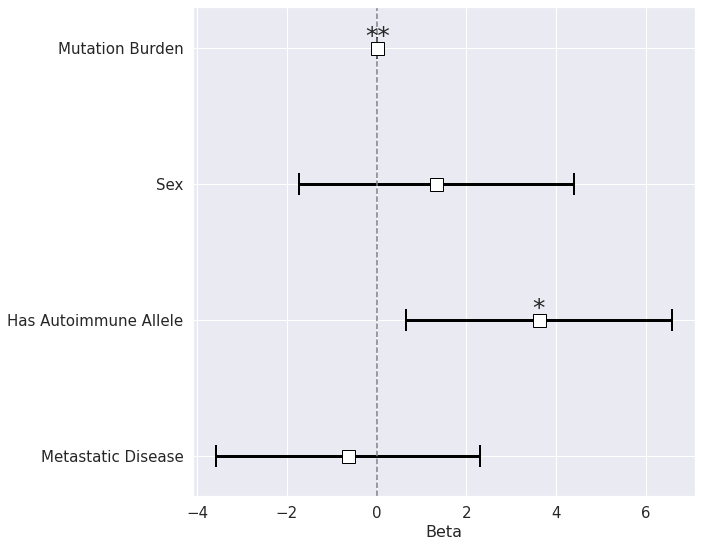

In [19]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.set(font_scale=1.1)
plt.errorbar(summaryDF.coef, summaryDF.Labels, xerr=summaryDF.DoubleTrouble, fmt='s', mfc = "white",color='black',
             ecolor='black', elinewidth=3, capsize = 11, markersize = 13, capthick = 2);

plt.ylim(-0.3,3.3)
plt.text(summaryDF.loc["HasProtection[T.True]", "coef"] - 0.16, 1.03, "*", fontsize = 25)
plt.text(summaryDF.loc["NumberMutations", "coef"] - 0.25, 3.03, "**", fontsize = 25)
plt.xlabel("Beta", fontsize = 16) 
ax.tick_params(labelsize=15)
plt.axvline(0,linestyle="--",color="gray")

**2c.3 Supplementary Figure 8b and relevant statistical analyses:**

Linear model: $$Age Of Diagnosis \sim AI status + Sex + Mutation Burden $$

In [20]:
#all individuals have num muts and sex information - evaluate these covariates with AI status in the context of the full discovery set
print("Discovery set size for this analysis is N = {} ".format(tcgaSummary.shape[0]))

discoveryAll = smf.ols(formula= 'Age ~ HasProtection+C_Sex+NumberMutations', data=tcgaSummary).fit() #, groups=valOnly["Study"]).fit() #smf.mixedlm(formula='zAge ~ zProtection', data=valOnly, groups=valOnly["Study"]).fit() 
summary = discoveryAll.summary()
summary.tables[1]

Discovery set size for this analysis is N = 451 


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,55.1356,1.194,46.159,0.000,52.788,57.483
HasProtection[T.True],4.0699,1.436,2.834,0.005,1.248,6.892
C_Sex[T.True],1.4603,1.481,0.986,0.325,-1.450,4.371
NumberMutations,0.0035,0.001,3.046,0.002,0.001,0.006


In [21]:
discoveryAll.pvalues

Intercept                3.558757e-172
HasProtection[T.True]     4.804651e-03
C_Sex[T.True]             3.246531e-01
NumberMutations           2.452813e-03
dtype: float64

In [22]:
resultsHTML = summary.tables[1].as_html()
summaryDF = pd.read_html(resultsHTML, header =0, index_col = 0)[0]
summaryDF["Labels"] = summaryDF.index
summaryDF["DoubleTrouble"] = 2*summaryDF["std err"]
summaryDF = summaryDF.drop(["Intercept"], axis = 0)
summaryDF.Labels = ["Has Autoimmune Allele", "Sex", "Mutation Burden"]
summaryDF

,coef,std err,t,P>|t|,[0.025,0.975],Labels,DoubleTrouble
HasProtection[T.True],4.0699,1.436,2.834,0.005,1.248,6.892,Has Autoimmune Allele,2.872
C_Sex[T.True],1.4603,1.481,0.986,0.325,-1.450,4.371,Sex,2.962
NumberMutations,0.0035,0.001,3.046,0.002,0.001,0.006,Mutation Burden,0.002


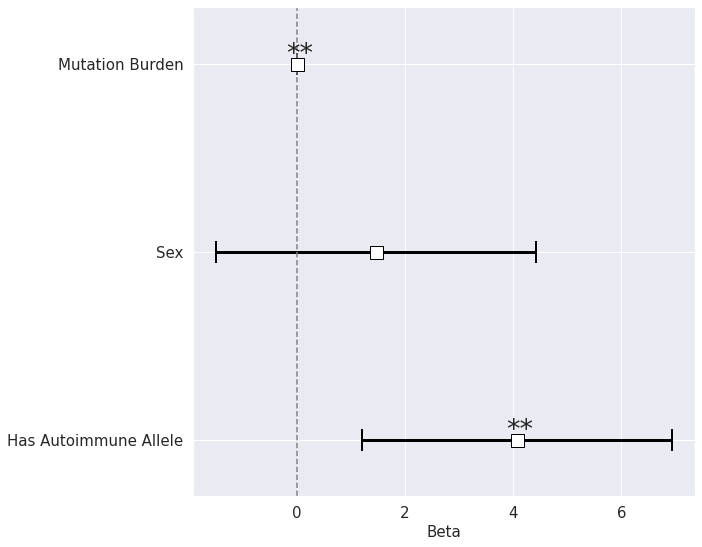

In [23]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.set(font_scale=1.1)
plt.errorbar(summaryDF.coef, summaryDF.Labels, xerr=summaryDF.DoubleTrouble, fmt='s', mfc = "white",color='black',
             ecolor='black', elinewidth=3, capsize = 11, markersize = 13, capthick = 2);

plt.ylim(-0.3,2.3)
plt.text(summaryDF.loc["HasProtection[T.True]", "coef"] - 0.2, 0.01, "**", fontsize = 27)
plt.text(summaryDF.loc["NumberMutations", "coef"] - 0.2, 2.01, "**", fontsize = 27)
plt.xlabel("Beta", fontsize = 15) 
ax.tick_params(labelsize=15)
plt.axvline(0,linestyle="--",color="gray")

**2c.4 Regression analysis for comparison with validation regression (same features):**

Linear model: $$Age Of Diagnosis \sim AI status + Sex$$

In [24]:
discoveryAIAndSex = smf.ols(formula= 'Age ~ HasProtection+C_Sex', data=tcgaSummary).fit()
aiAndSexSummary = discoveryAIAndSex.summary()
aiAndSexSummary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.6992,1.088,52.090,0.000,54.560,58.838
HasProtection[T.True],4.0019,1.449,2.762,0.006,1.154,6.850
C_Sex[T.True],0.7269,1.475,0.493,0.622,-2.171,3.625


In [25]:
print("The discovery cohort (N = {0}) AI allele carrier status Beta (sex as lone covariate) is {1:.3f} with a p-value of {2:.3f}".format(tcgaSummary.shape[0],discoveryAIAndSex.params["HasProtection[T.True]"], discoveryAIAndSex.pvalues["HasProtection[T.True]"]))

The discovery cohort (N = 451) AI allele carrier status Beta (sex as lone covariate) is 4.002 with a p-value of 0.006


## 2d. Figure 1E

**Statistical Test**: Linear model ->  Age ~ Number AI Alleles 

In [26]:
discoveryNumAllelesEffect = smf.ols(formula= 'Age ~ NumTotalAIAlleles', data=tcgaSummary).fit() #, groups=valOnly["Study"]).fit() #smf.mixedlm(formula='zAge ~ zProtection', data=valOnly, groups=valOnly["Study"]).fit() 
summary = discoveryNumAllelesEffect.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,57.0531,0.885,64.467,0.000,55.314,58.792
NumTotalAIAlleles,2.5988,0.846,3.070,0.002,0.935,4.262


In [27]:
tcgaSummary["PlottingNumTotalAIAlleles"] = ["3+" if el >= 3 else str(el) for el in tcgaSummary.NumTotalAIAlleles]

Generate figure: 

(15.0, 100.0)

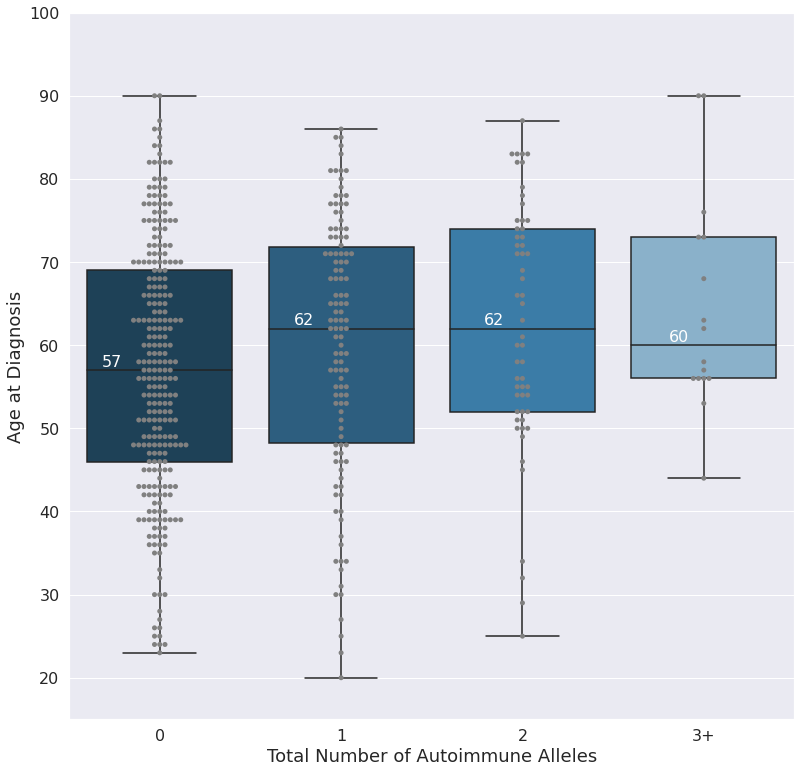

In [28]:
colorPalette = {"0":"#154360" , "1":"#1F618D", "2":"#2980B9" , "3+":"#7FB3D5"}
plt.figure(figsize=(13,13))
sns.boxplot(data=tcgaSummary, x="PlottingNumTotalAIAlleles", y="Age", order = ["0", "1", "2", "3+"], palette=colorPalette)
sns.swarmplot(data=tcgaSummary, x="PlottingNumTotalAIAlleles", y="Age", color = "grey", dodge = True, order = ["0", "1", "2", "3+"])

plt.text(-.32, 57.5, str(int(np.median(tcgaSummary[(tcgaSummary.PlottingNumTotalAIAlleles == "0")]["Age"]))), color = "white", fontsize = 16)
plt.text(0.74, 62.5, str(int(np.median(tcgaSummary[(tcgaSummary.PlottingNumTotalAIAlleles == "1")]["Age"]))), color = "white", fontsize = 16)
plt.text(1.79, 62.5, str(int(np.median(tcgaSummary[(tcgaSummary.PlottingNumTotalAIAlleles == "2")]["Age"]))), color = "white", fontsize = 16)
plt.text(2.81, 60.5, str(int(np.median(tcgaSummary[(tcgaSummary.PlottingNumTotalAIAlleles == "3+")]["Age"]))), color = "white", fontsize = 16)

plt.xlabel("Total Number of Autoimmune Alleles", fontsize = 18)
plt.ylabel("Age at Diagnosis", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(15,100)

In [29]:
#Get the number of individuals in each bucket
tcgaSummary.PlottingNumTotalAIAlleles.value_counts()

0     261
1     118
2      56
3+     16
Name: PlottingNumTotalAIAlleles, dtype: int64